In [0]:
# !pip uninstall tensorflow -y
# !pip install tensorflow==2.1

In [2]:
# Run this one if using google colab
from google.colab import drive
import sys
import os

drive.mount('/content/gdrive')
sys.path.append("/content/xray_code/python_code")

if not os.path.exists("/content/xray_code"):
  !cp -r "/content/gdrive/My Drive/xray_code/" "/content/xray_code"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%load_ext autoreload
%autoreload 2

from utils import *
from ml_utils import XrayTF
from tqdm import tqdm_notebook as tqdm
from threading import Thread
from constants import LOCAL_IMAGES_LOCATION

import urllib.request as req
import matplotlib.pyplot as plt
import numpy as np
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load csv if exist, if not get the original one and parse it


In [4]:
"""
SICKNESS = "Infiltration"
SICKNESS = "Pneumonia"
SICKNESS = "Mass"
SICKNESS = "Pneumothorax"
"""

SICKNESS = "Pneumothorax"
csv_file = "normalized_xray_without_full_path.csv"
csv_file_full_path = f'/content/gdrive/My Drive/xray_code/sheet/{csv_file}'

IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCH = 1000

pd.set_option('display.max_colwidth', -1)


# take existing if it exist
if os.path.exists(csv_file_full_path):
    df = pd.read_csv(csv_file_full_path)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
else:
    df = get_data_sheet()
    df = normalize_data_frame(df)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
    xray_class.df.to_csv(csv_file_full_path, index=False)

xray_class.df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()


,Image Index,labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,image_width,image_width.1,x_pixel_spacing,y_pixel_spacing
0,https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
2,https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
3,https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
4,https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168


# Analyze our data set
- take a look at the distribution
- prepare data before splitting to test and train
  - Get image based on xray Position
  - Select a sickness and balance them
- Generate Age histogram

In [5]:
print(xray_class.df["View Position"].value_counts())
print("="*50)
print(xray_class.df.labels.value_counts())

PA    81630
AP    59907
Name: View Position, dtype: int64
No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                6331 
Mass                  5782 
Pneumothorax          5302 
Consolidation         4667 
Pleural_Thickening    3385 
Cardiomegaly          2776 
Emphysema             2516 
Edema                 2303 
Fibrosis              1686 
Pneumonia             1431 
Hernia                227  
Name: labels, dtype: int64


In [6]:
# Pick a sickness
xray_class.use_one_label(SICKNESS, balance=True)

# Verify how balanced our data is
print(xray_class.df.labels.value_counts())
print(xray_class.df["Patient Gender"].value_counts())

No Finding      5302
Pneumothorax    5302
Name: labels, dtype: int64
M    5695
F    4909
Name: Patient Gender, dtype: int64


(0.0, 100.0)

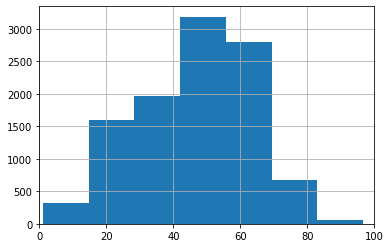

In [7]:
xray_class.df["Patient Age"].hist(bins=30).set_xlim(0,100)

# Download our data
- Parallel download from digital ocean
- prepend system path after download

In [8]:
!rm -rf /content/images
if not os.path.exists(LOCAL_IMAGES_LOCATION):
  !mkdir /content/images

  class Downloader(Thread):
    def __init__(self, file_url, save_path):
        Thread.__init__(self)
        self.file_url = file_url
        self.save_path = save_path

    def run(self):
        remaining_download_tries = 15

        while remaining_download_tries > 0:
            try:
                req.urlretrieve(self.file_url, self.save_path)
                time.sleep(0.1)
            except:
                print("error downloading " + self.file_url +
                      " on trial no: " + str(16 - remaining_download_tries))
                remaining_download_tries = remaining_download_tries - 1
                continue
            else:
                break

  xray_class.df["Image Index"].apply(lambda x: Downloader(x, LOCAL_IMAGES_LOCATION + x.split('/')[-1] ).start() )

error downloading https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00011355_029.png on trial no: 1error downloading https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00011355_044.png on trial no: 1

error downloading https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00011355_045.png on trial no: 1
error downloading https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00011355_030.png on trial no: 1error downloading https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00011355_046.png on trial no: 1

error downloading https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00017046_008.png on trial no: 1
error downloading https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00011355_025.png on trial no: 1
error downloading https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00009349_025.png on trial no: 1
error downloading https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00017747_057.png on trial no: 1
error downloading https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00023075_005

In [9]:
#  let's now append the full system path
xray_class.df["Image Index"] = xray_class.df["Image Index"].apply(lambda x : LOCAL_IMAGES_LOCATION + x.split('/')[-1])
xray_class.df.head()

,Image Index,labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,image_width,image_width.1,x_pixel_spacing,y_pixel_spacing
21828,/content/images/00006763_000.png,No Finding,0,6763,13,M,PA,2048,2500,0.171000,0.171000
76932,/content/images/00024141_000.png,No Finding,0,24141,26,M,PA,2992,2991,0.143000,0.143000
86712,/content/images/00028639_001.png,No Finding,1,28639,28,F,PA,1829,2021,0.194311,0.194311
49540,/content/images/00014768_004.png,No Finding,4,14768,11,M,AP,2500,2048,0.168000,0.168000
81020,/content/images/00026243_000.png,No Finding,0,26243,66,M,PA,2992,2991,0.143000,0.143000


# Pre-processing of images and label
- split dataframe accordingly with equal numbers of labels in test and train
- batches image
- show image

In [10]:
# Split them into training and validation using NUM_IMAGES 
train_df, valid_df, test_df = xray_class.get_test_train_split_data(len(xray_class.df))

print(train_df.labels.value_counts())
print("="*50)
print(valid_df.labels.value_counts())
print("="*50)
print(test_df.labels.value_counts())


Pneumothorax    4242
No Finding      4241
Name: labels, dtype: int64
No Finding      854
Pneumothorax    842
Name: labels, dtype: int64
Pneumothorax    218
No Finding      207
Name: labels, dtype: int64


In [11]:
# Create training and validation data batches using ImageDataGenerator
train_data = xray_class.generate_image(train_df)
val_data   = xray_class.generate_image(valid_df)
test_data   = xray_class.generate_image(test_df)

Found 8483 validated image filenames belonging to 2 classes.
Found 1696 validated image filenames belonging to 2 classes.
Found 425 validated image filenames belonging to 2 classes.


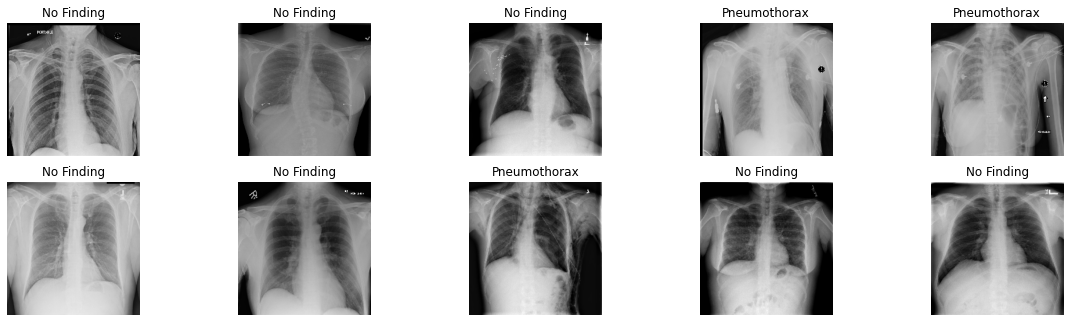

In [12]:
train_images, train_labels = next(train_data)
xray_class.show_25_images(train_images, train_labels)

# Perform model trainining
- fit our data using Categorical classification with metrics of accuracy and optimization Adam
- validate data
- save our model

In [0]:
if xray_class.model_exist(SICKNESS):
    model = xray_class.model_exist(SICKNESS)
    a, b = model.evaluate(test_data)
else:
    model, stop = xray_class.train_model(EPOCH, train_data, val_data)
    a, b = model.evaluate(test_data)

    filename= f"{SICKNESS}_{b:.2f}"
    xray_class.save_model(model, filename)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              55875273  
_________________________________________________________________
dense (Dense)                (None, 512)               513024    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 56,651,979
Trainable params: 776,706
Non-trainable params: 55,875,273
______________________________________

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 266 steps, validate for 53 steps
Epoch 1/1000
266/266 [==============================] - 161s 606ms/step - loss: 0.8816 - accuracy: 0.6308 - val_loss: 0.5909 - val_accuracy: 0.6881
Epoch 2/1000
266/266 [==============================] - 147s 551ms/step - loss: 0.5976 - accuracy: 0.6932 - val_loss: 0.5836 - val_accuracy: 0.7099
Epoch 3/1000
266/266 [==============================] - 144s 541ms/step - loss: 0.5841 - accuracy: 0.6998 - val_loss: 0.5785 - val_accuracy: 0.7070
Epoch 4/1000
266/266 [==============================] - 144s 540ms/step - loss: 0.5667 - accuracy: 0.7158 - val_loss: 0.5684 - val_accuracy: 0.7276
Epoch 5/1000
266/266 [==============================] - 143s 539ms/step - loss: 0.5632 - accuracy: 0.7145 - val_loss: 0.5789 - val_accuracy: 0.7176
Epoch 6/1000
266/266 [==============================] - 144s 541ms/step - loss: 0.5628 - accuracy: 0.7183 - val_loss: 0.5697 - val_accuracy: 0.7229
Epoch 7/1000
266/266 [==============================] - 144s 543ms/st

In [0]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs_range = range(stop.stopped_epoch + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Post processing
- Predict our validation data
- load tensorboard
- Show images and percentage of accuracy for those prediction

In [0]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(test_data, verbose=1)

In [0]:
# Let's check a few predictions and their different values
test_images, test_labels = next(test_data)

i_multiplier = 0
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  xray_class.plot_pred(prediction_probabilities=predictions,
            labels=test_labels,
            images=test_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  xray_class.plot_pred_conf(prediction_probabilities=predictions,
                labels=test_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# Evaluating our model
- confusion matrix
- classification report
- loss and accuracy

In [0]:
print(f"Loss : {a}, Accuracy: {b}")

In [0]:
y_test = [xray_class.get_label(x) for x in predictions] # convert [0,25, 0.75] -> "No Finding/Effusion"
y_val = [xray_class.get_unique_labels()[x] for x in test_data.labels]


xray_class.generate_confusion_matrix(y_test, y_val)

In [0]:
xray_class.generate_classification_report(y_test, y_val)